In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import math
import os
import random
from functools import partial
from decimal import Decimal
import numpy as np
import scipy.io as sio
import pysindy as ps
from tqdm import trange

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

from utils import *
from skimage.restoration import estimate_sigma
import bm3d
from okridge.solvel0 import *
from best_subset import backward_refinement, brute_force_all_subsets
from UBIC import *
from kneed import KneeLocator

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

/Users/pongpisit/anaconda3/envs/pysr_latest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_poly = 4
n_derivatives = 5
n_modules = 8

In [3]:
data_path = "../PDE-Discovery-EC/Datasets/"
data = sio.loadmat(os.path.join(data_path, "burgers.mat"))
u_clean = (data['usol']).real; u = u_clean.copy()
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]; dx = x[2]-x[1]

### Add noise

In [4]:
np.random.seed(0)
noise_lv = float(50)
print("Noise level:", noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
u = u + noise

Noise level: 50.0


In [5]:
kernel = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e3)) + \
        WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))

xx = colvec(x)
u_mean = np.copy(u)
u_std = np.ones(u.shape)
for i in trange(len(t)):    
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, 
                                   n_restarts_optimizer=10 # 20
                                  )

    gpr.fit(xx, u_mean[:, i])
    um, ustd = gpr.predict(xx, return_std=True)
    u_mean[:, i] = um
    u_std[:, i] = ustd
    
cutoff_ws = knee(range(1, 21), 
                 [u_std[ws:-ws, :].std() for ws in range(1, 21)], 
                 'linear')
cutoff_ws

100%|████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:23<00:00,  1.42s/it]


5

### Denoise

In [6]:
est_sigma = u_std.mean() # max also works well
# est_sigma = (est_sigma+estimate_sigma(u))/2
u = bm3d.bm3d(u, sigma_psd=est_sigma, 
              stage_arg=bm3d.BM3DStages.ALL_STAGES, 
              blockmatches=(False, False))

In [7]:
# cutoff_ws = 0 # No int cutoff_ws
if cutoff_ws > 0:
    u = u[cutoff_ws:-cutoff_ws, :]
    x = x[cutoff_ws:-cutoff_ws]
xt = np.array([x.reshape(-1, 1), t.reshape(1, -1)], dtype=object)
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [8]:
function_library = ps.PolynomialLibrary(degree=n_poly, include_bias=False)

weak_lib = ps.WeakPDELibrary(
    function_library=function_library,
    derivative_order=n_derivatives,
    spatiotemporal_grid=XT,
    include_bias=True,
    diff_kwargs={"is_uniform":True},
    K=10000
)

X_pre = np.array(weak_lib.fit_transform(np.expand_dims(u, -1)))
y_pre = weak_lib.convert_u_dot_integral(np.expand_dims(u, -1))

In [9]:
base_poly = np.array([[p, 0] for p in range(1, n_poly+1)])
base_derivative = np.array([[0, d] for d in range(1, n_derivatives+1)])
modules = [(0, 0)] if weak_lib.include_bias else []
modules += [(p, 0) for p in range(1, n_poly+1)] + \
            [(0, d) for d in range(1, n_derivatives+1)] + \
            [tuple(p+d) for d in base_derivative for p in base_poly]
assert len(modules) == len(weak_lib.get_feature_names())
base_features = dict(zip(modules, X_pre.T))
u_t = y_pre.copy()

### Genetic algorithm with NSGA-II

In [10]:
class PdeDiscoveryProblem(ElementwiseProblem):
    def __init__(self, n_poly, n_derivatives, n_modules, 
                 base_features, u_t, epsilon=0):
        super().__init__(n_var=1, n_obj=2, n_ieq_constr=0)
        self.n_poly = n_poly
        self.n_derivatives = n_derivatives
        self.n_modules = n_modules
        self.base_features = base_features
        self.u_t = u_t
        self.epsilon = epsilon
        self.sample_size = np.prod(self.u_t.shape)

    def _evaluate(self, X, out, *args, **kwargs):
        genome = X[0]
        coeff, mse = self.compute_genome_coefficient(genome)
        mse = mse/self.sample_size
        complexity_penalty = self.epsilon*len(genome)
        out["F"] = [mse, complexity_penalty]
        
    def numericalize_genome(self, genome):
        return np.stack([self.base_features[tuple(module)] 
                         for module in genome], axis=-1)

    def compute_genome_coefficient(self, genome):
        features = self.numericalize_genome(genome)
        features = features.reshape(-1, features.shape[-1])
        coeff, error, _, _ = np.linalg.lstsq(features, self.u_t, rcond=None)
        return coeff, error[0]
    
    def generate_module(self, n_poly, n_derivatives):
        return (random.randint(0, n_poly), random.randint(0, n_derivatives))
    
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
    
class PopulationSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, 1), None, dtype=object)
        X_set = set()
        i = 0
        while i < n_samples:
            n_modules = random.randint(1, problem.n_modules)
            genome = frozenset(problem.generate_module(problem.n_poly, problem.n_derivatives) for _ in range(n_modules))
            if len(genome) > 0 and genome not in X_set:
                X_set.add(genome)
                X[i, 0] = genome
                i += 1
        return X
    
class DuplicateElimination(ElementwiseDuplicateElimination):
    def is_equal(self, g1, g2):
        return g1.X[0] == g2.X[0]

In [11]:
class GenomeCrossover(Crossover):
    def __init__(self):
        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):
        # The input of has the following shape (n_parents, n_matings, n_var)
        _, n_matings, n_var = X.shape

        # The output owith the shape (n_offsprings, n_matings, n_var)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, None, dtype=object)
        
        # for each mating provided
        for k in range(n_matings):
            # get the first and the second parent          
            Y[0, k, 0], Y[1, k, 0] = self.crossover_permutation(X[0, k, 0], X[1, k, 0])
            
        return Y
    
    def crossover_permutation(self, genome1, genome2):
        collection = list(genome1) + list(genome2)
        random.shuffle(collection)
        return frozenset(collection[:len(genome1)]), frozenset(collection[len(genome1):])
    
class GenomeMutation(Mutation):
    def __init__(self, add_rate=0.4, del_rate=0.5, order_rate=0.4):
        super().__init__()
        self.add_rate = add_rate
        self.del_rate = del_rate
        self.order_rate = order_rate

    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            if random.random() < self.add_rate:
                X[i, 0] = self.add_mutate(problem, X[i, 0])
            if random.random() < self.del_rate:
                X[i, 0] = self.del_mutate(problem, X[i, 0])
            if random.random() < self.order_rate:
                X[i, 0] = self.module_mutate(problem, X[i, 0])
        return X
    
    def add_mutate(self, problem, genome, max_iter=3):
        for _ in range(max_iter):
            new_module = problem.generate_module(problem.n_poly, problem.n_derivatives)
            if new_module not in genome:
                return genome.union(frozenset({new_module}))
        return genome
    
    def del_mutate(self, problem, genome, max_iter=3):
        genome = list(genome)
        lg = len(genome)
        if lg > 0:
            if lg == 1:
                for _ in range(max_iter):
                    new_module = problem.generate_module(problem.n_poly, problem.n_derivatives)
                    if new_module != genome[0]:
                        return frozenset({new_module})
            else:
                genome.pop(random.randint(0, lg-1))
        return frozenset(genome)
    
    def module_mutate(self, problem, genome):
        if len(genome) == 0:
            return genome
        genome = set(genome)
        genome.remove(random.choice(list(genome)))
        for _ in range(3):
            new_module = problem.generate_module(problem.n_poly, problem.n_derivatives)
            if new_module not in genome:
                genome.add(new_module)
                return frozenset(genome)
        return frozenset(genome)

In [12]:
pop_size = 500
problem = PdeDiscoveryProblem(n_poly, n_derivatives, n_modules, 
                              base_features, u_t, 0)
pop = PopulationSampling().do(problem, pop_size)
pop = [[pop[i].X[0]] for i in range(len(pop))]
epi = 10**(sci_format(np.median(problem.evaluate(pop)[:, 0]))[1])
problem.set_epsilon(epi)
del pop

In [13]:
termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-8,
    period=50,
    n_max_gen=100,
    n_max_evals=100000
)

algorithm = NSGA2(pop_size=pop_size,
                  sampling=PopulationSampling(),
                  crossover=GenomeCrossover(),
                  mutation=GenomeMutation(),
                  eliminate_duplicates=DuplicateElimination())

res = minimize(problem,
               algorithm,
               termination=termination,
               verbose=True)

pareto_optimal_models = res.X[np.argsort(res.F[:, 0]+res.F[:, 1])]
best = pareto_optimal_models[0]
best

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |      6 |             - |             -
     2 |     1000 |      5 |  0.0672466877 |             f
     3 |     1500 |      6 |  0.0299066015 |             f
     4 |     2000 |      7 |  0.0092640693 |         ideal
     5 |     2500 |      8 |  0.0181027231 |             f
     6 |     3000 |      8 |  0.0026745071 |             f
     7 |     3500 |      8 |  0.0069654726 |         ideal
     8 |     4000 |      8 |  0.0000113319 |             f
     9 |     4500 |      8 |  0.0059219847 |             f
    10 |     5000 |      9 |  0.2222222222 |         nadir
    11 |     5500 |      9 |  0.0005359251 |             f
    12 |     6000 |      9 |  0.0044353518 |         ideal
    13 |     6500 |      9 |  0.000000E+00 |             f
    14 |     7000 |      9 |  0.000000E+00 |             f
    15 |     7500 |      9 |  0.0002613881 |             f
    16 |     8000 |      9 |  0.0026570828 |         ide

array([frozenset({(1, 1), (0, 2)})], dtype=object)

In [14]:
significance_threshold = 0.95

effective_candidates = frozenset()
for i in range(len(pareto_optimal_models)):
    effective_candidates = effective_candidates.union(pareto_optimal_models[i][0])
    
effective_candidates = {_: 0.0 for _ in effective_candidates}
for i in range(len(pareto_optimal_models)):
    potential_pde = list(pareto_optimal_models[i][0])
    important_scores = shap_linear_importance(problem.numericalize_genome(potential_pde), 
                                              y_pre, scale=True)
    for j in range(len(potential_pde)):
        effective_candidates[potential_pde[j]] += important_scores[j]
        
total_score = sum(effective_candidates.values())
for _ in effective_candidates:
    effective_candidates[_] = effective_candidates[_]/total_score
    
effective_candidates = sorted(effective_candidates.items(), key=lambda _: _[1], reverse=True)
cumulative_sum = 0
top_candidates = []
for i in range(len(effective_candidates)):
    cumulative_sum += effective_candidates[i][1]
    top_candidates.append(effective_candidates[i][0])
    if cumulative_sum > significance_threshold:
        break

top_candidates = np.array(top_candidates)[np.nonzero(linear_model.ARDRegression(max_iter=500, fit_intercept=False).fit(problem.numericalize_genome(top_candidates), y_pre.ravel()).coef_)[0]]
X_pre_top = problem.numericalize_genome(top_candidates)

top_candidates

array([[1, 1],
       [0, 2],
       [3, 0],
       [4, 0],
       [2, 3],
       [4, 3],
       [3, 3],
       [2, 2],
       [2, 1],
       [1, 3]])

### Best-subset selection

In [15]:
_, best_subsets = okridge_solvel0_full(X_pre_top, y_pre, 
                                       k=100, norm='l2')
best_subsets = backward_refinement(best_subsets, (X_pre_top, y_pre), 
                                   ic_type='bic', verbose=False).get_best_subsets()
best_subsets = [tuple(best_subsets[-1][_] for _ in bs) 
                for bs in brute_force_all_subsets(X_pre_top[:, best_subsets[-1]], y_pre)[1]]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


### Model selection using UBIC

In [16]:
# TODO: Calculate post_means for ARDRegression as well (Implement the ard_uncertainties function)
ard_uns = []
threshold_lambda = 5e5 # must pass assert 
for bs in best_subsets:
    ard = linear_model.ARDRegression(fit_intercept=False, 
                                     compute_score=True,
                                     threshold_lambda=threshold_lambda)
    ard.fit(X_pre_top[:, bs], y_pre.ravel())
    print(len(bs), end=', ')
    assert len(bs) == len(np.nonzero(ard.coef_)[0])
    pde_uncert = np.sqrt(np.diag(ard.sigma_)).sum()
    ard_uns.append(pde_uncert)
ard_uns = np.array(ard_uns)
ard_uns = ard_uns/min(ard_uns)
ard_uns

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

array([ 1.35746615,  1.        ,  2.19097732,  2.70358767, 10.7015825 ,
       16.99632784, 24.01015884, 26.99876478, 30.72408931, 55.46600104])

In [17]:
tau = 3
verbose = True
# scale = 1 <- generalized UBIC
scale = np.log(len(y_pre))
per = 75 # 80

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre_top, y_pre), 
                                               u_type='cv1', take_sqrt=True, 
                                               ridge_lambda=0, 
                                               threshold=0)
# b_uns = ard_uns # USE ard_uns INSTEAD
predictions = X_pre_top@post_means
print(b_bics)
print(b_uns)
b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
try:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
    thres = math.ceil(sci_format(thres)[0])*10**sci_format(thres)[1]
except IndexError:
    thres = 1/40
min_thres = 1/40
thres = max(thres, min_thres)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    # assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
bc_seq = [last_bc]
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = np.nan
    if diff_com != 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    if last_bc not in bc_seq:
        bc_seq.append(last_bc)

best_bc = knee(range(0, len(last_ubic)), last_ubic, 'linear')
if best_bc == 0 and last_bc != 0 and abs((b_bics[last_bc]-b_bics[0])/(b_bics[0]*last_bc)) > thres:
    best_bc = knee(range(1, len(last_ubic)), last_ubic[1:], 'linear')

if best_bc is None:
    best_bc = last_bc
    alt_bc = bc_seq[-2] if len(bc_seq) > 1 else last_bc-10
    cond = abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) or \
            abs((b_bics[last_bc]-b_bics[alt_bc])/(b_bics[alt_bc]*(last_bc-alt_bc)))
    if cond < thres: 
        best_bc = np.argmin(last_ubic[:alt_bc+1])
    
last_lam = round(last_lam, 8)
last_lam, last_ubic, last_bc, best_bc

[-77288.18365126841, -87856.74397132633, -88188.00622019406, -88796.73368016431, -88978.14863928674, -89123.26988296318, -89343.48165972893, -89366.87289771238, -89487.00685979772, -89505.06476430832]
[ 1.63344207  1.          2.05903257  2.30713653  6.70406017  8.13156301
  8.95213823  9.81238548  9.77829069 15.17698828]
threshold: 0.025
max_lam: 3.979499423961188
1 <---> 1 inf
1 <---> 3 0.005349559216221144


(2.65299962,
 array([-70521.45075064, -83714.12207843, -79658.21281272, -79239.13937822,
        -61205.76222549, -55437.27894635, -52258.15784496, -48717.86999237,
        -48979.24575331, -26632.54084272]),
 1,
 1)

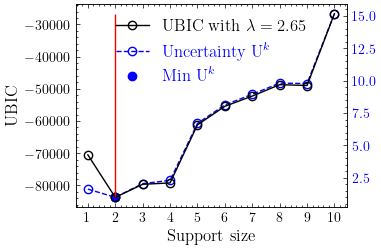

In [18]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}$", fontsize=12)
    ax.set_xlabel("Support size", fontsize=12)
    ax.vlines(best_bc+1, min(last_ubic), max(last_ubic), color='red')
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {round(abs(last_lam), 2)}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=12)
    
    plt.show()

In [19]:
# Some ideas
# Better knee detection algorithm